In [29]:
# --- EDA on REE Demand + Spot Price (clean, concise) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [30]:
# ---------------------------
# Load & clean
# ---------------------------
Dataset = pd.read_csv("dataset.csv", sep=',') #energy in MWh, last column price in eur/MWh

# datetime: make tz-naive (consistent)
Dataset['timestamp'] = pd.to_datetime(Dataset['timestamp'], errors='coerce', utc=True).dt.tz_convert(None)

# Remove NA / duplicates / sort
Dataset = (
    Dataset
    .dropna(subset=['timestamp'])
    .drop_duplicates(subset=['timestamp'])
    .sort_values('timestamp')
    .reset_index(drop=True)
)

Dataset.head() #variables hour, day_of_week and month are considered already, mondays are 0, months go from 1 to 12



,timestamp,scheduled_demand,actual_national_demand,dam_allocated_energy_spain,scheduled_coal,scheduled_combined_cycle,scheduled_wind,scheduled_hydraulic,scheduled_total_import,scheduled_nuclear,...,actual_coal_generation,actual_combined_cycle_generation,actual_wind_generation,actual_hydraulic_generation,actual_nuclear_generation,actual_solar_pv_generation,hour,day_of_week,month,spot_price_spain
0,2022-08-31 22:00:00,25915.0,27690.750000,21730.8,695.00,14748.950,4387.050,615.975,298.8,6869.9,...,685.750000,15237.583333,4423.916667,1222.833333,6901.750000,26.500000,0,3,9,200.00
1,2022-08-31 23:00:00,24494.5,26274.083333,20572.7,750.00,14255.600,4008.900,586.100,325.2,6881.9,...,751.000000,14812.500000,4039.500000,948.583333,6904.416667,26.500000,1,3,9,181.99
2,2022-09-01 00:00:00,23455.0,25140.583333,19453.6,777.50,13644.750,3547.500,536.500,299.9,6873.9,...,813.750000,14522.333333,3361.083333,381.916667,6904.916667,26.166667,2,3,9,178.54
3,2022-09-01 01:00:00,23008.0,24582.416667,18995.7,802.50,13736.500,3188.650,534.600,308.8,6879.9,...,810.500000,14344.583333,2832.750000,363.333333,6907.833333,26.500000,3,3,9,178.54
4,2022-09-01 02:00:00,22737.0,24292.166667,19103.8,816.25,13706.825,2594.225,555.700,308.0,6873.9,...,826.833333,14415.333333,2446.416667,532.750000,6908.333333,26.416667,4,3,9,181.23


In [31]:
# ---------------------------
# First impression
# ---------------------------
Dataset.describe()

,timestamp,scheduled_demand,actual_national_demand,dam_allocated_energy_spain,scheduled_coal,scheduled_combined_cycle,scheduled_wind,scheduled_hydraulic,scheduled_total_import,scheduled_nuclear,...,actual_coal_generation,actual_combined_cycle_generation,actual_wind_generation,actual_hydraulic_generation,actual_nuclear_generation,actual_solar_pv_generation,hour,day_of_week,month,spot_price_spain
count,26304,26302.000000,26221.000000,26289.000000,25080.000000,26266.000000,26266.000000,26266.000000,26178.000000,26266.000000,...,26302.000000,26221.000000,26221.000000,26221.000000,26221.000000,26221.000000,26304.000000,26304.000000,26304.000000,26304.000000
mean,2024-03-01 21:30:00,26407.768468,28216.378582,20203.732276,408.709494,4206.297957,6879.659566,3012.985097,1911.264616,6083.731763,...,390.836749,5102.684035,6885.146076,3109.744004,6093.051645,4685.597373,11.500000,3.005474,6.522696,77.545857
min,2022-08-31 22:00:00,0.000000,2100.666667,80.300000,15.000000,302.900000,301.125000,148.125000,0.200000,142.000000,...,0.000000,672.666667,80.083333,-3690.166667,0.000000,0.000000,0.000000,0.000000,1.000000,-15.000000
25%,2023-06-01 21:45:00,22925.187500,24492.583333,16936.300000,243.000000,1981.137500,3602.518750,1298.737500,888.025000,5095.000000,...,248.916667,2833.916667,3669.333333,832.166667,5106.000000,30.166667,5.750000,1.000000,4.000000,35.010000
50%,2024-03-01 21:30:00,26446.125000,28280.166667,19691.300000,320.000000,3319.712500,6103.775000,2624.050000,1824.650000,6499.400000,...,308.083333,4253.916667,6179.166667,2932.500000,6490.833333,325.333333,11.500000,3.000000,7.000000,84.200000
75%,2024-11-30 21:15:00,29559.687500,31564.000000,23108.700000,487.462500,5689.350000,9496.906250,4355.081250,2808.000000,6945.900000,...,490.895833,6661.416667,9461.083333,5310.750000,6987.416667,9678.750000,17.250000,5.000000,10.000000,113.500000
max,2025-08-31 21:00:00,39866.750000,42126.000000,36294.900000,1655.000000,17054.625000,21271.000000,9393.675000,8100.325000,12101.400000,...,1576.250000,18216.250000,20908.166667,11695.916667,7140.416667,23220.916667,23.000000,6.000000,12.000000,300.000000
std,NaN,4351.479204,4520.717616,4397.696556,233.956958,2994.971911,4083.082989,1997.575420,1176.420914,1073.778279,...,247.173132,3036.824465,4007.116740,3082.350067,1095.668374,6003.637684,6.922318,1.999574,3.449047,49.851867


In [32]:
#actual hydraulic generation has negative values which at first sight seems like an error, checking the ESIOS website https://www.esios.ree.es/en/analysis/546?vis=1&start_date=01-09-2022T00%3A00&end_date=31-08-2025T23%3A55&compare_start_date=31-08-2022T00%3A00&groupby=hour
#the data is correct, the same as the Red Electrica
print("Statistical summary of actual_hydraulic_generation:")
print(Dataset['actual_hydraulic_generation'].describe())
print(f"\nNumber of negative values: {len(Dataset[Dataset['actual_hydraulic_generation'] < 0])}")
print(f"Percentage of negative values: {len(Dataset[Dataset['actual_hydraulic_generation'] < 0]) / len(Dataset) * 100:.2f}%")

Statistical summary of actual_hydraulic_generation:
count    26221.000000
mean      3109.744004
std       3082.350067
min      -3690.166667
25%        832.166667
50%       2932.500000
75%       5310.750000
max      11695.916667
Name: actual_hydraulic_generation, dtype: float64

Number of negative values: 4478
Percentage of negative values: 17.02%


In [33]:
#negative values represent energy consumption rather than generation, corresponding to the pumping of water to higher reservoirs
#in order to generate electricity when demand and price are higher than at the time of pumping


Basic Statistics for Spot Price Spain:
count    26304.000000
mean        77.545857
std         49.851867
min        -15.000000
25%         35.010000
50%         84.200000
75%        113.500000
max        300.000000
Name: spot_price_spain, dtype: float64


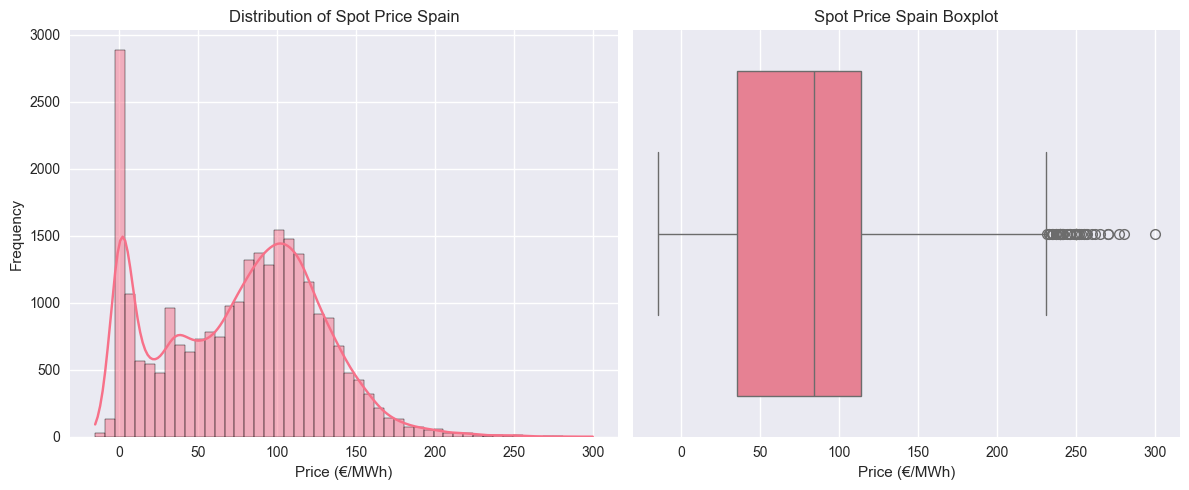

In [34]:
# ---------------------------
# Basic stats & distributions for the price (target variable)
# ---------------------------
print("Basic Statistics for Spot Price Spain:")
print(Dataset['spot_price_spain'].describe())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(Dataset['spot_price_spain'], bins=50, kde=True)
plt.title('Distribution of Spot Price Spain')
plt.xlabel('Price (€/MWh)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=Dataset['spot_price_spain'])
plt.title("Spot Price Spain Boxplot")
plt.xlabel('Price (€/MWh)')

plt.tight_layout()
plt.show()


ANALYSIS FOR: scheduled_demand
count    26302.000000
mean     26407.768468
std       4351.479204
min          0.000000
25%      22925.187500
50%      26446.125000
75%      29559.687500
max      39866.750000
Name: scheduled_demand, dtype: float64

Additional Stats:
Skewness: -0.134
Kurtosis: 0.883
Missing values: 2
Zero values: 35 (0.13%)


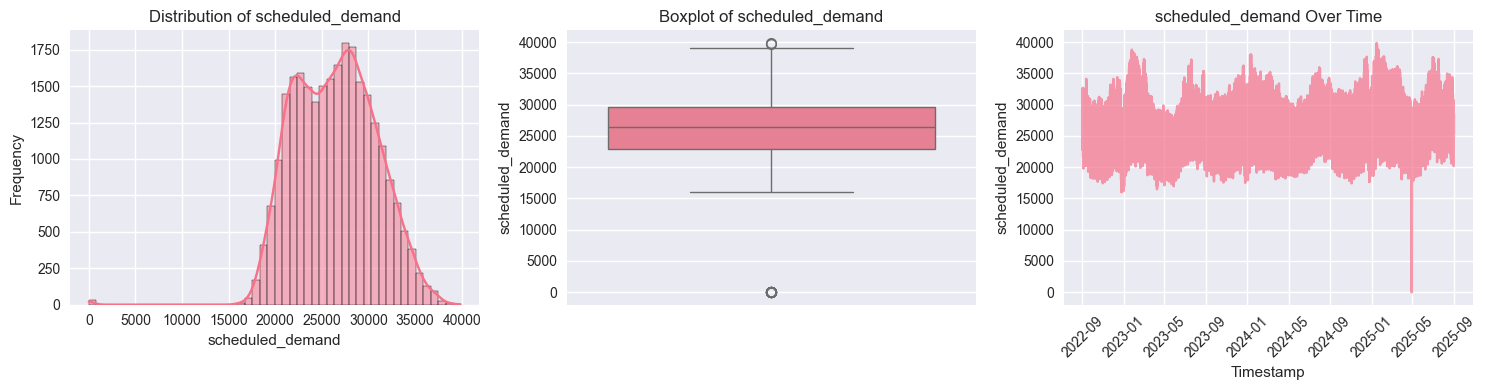


ANALYSIS FOR: actual_national_demand
count    26221.000000
mean     28216.378582
std       4520.717616
min       2100.666667
25%      24492.583333
50%      28280.166667
75%      31564.000000
max      42126.000000
Name: actual_national_demand, dtype: float64

Additional Stats:
Skewness: 0.091
Kurtosis: -0.574
Missing values: 83
Zero values: 0 (0.00%)


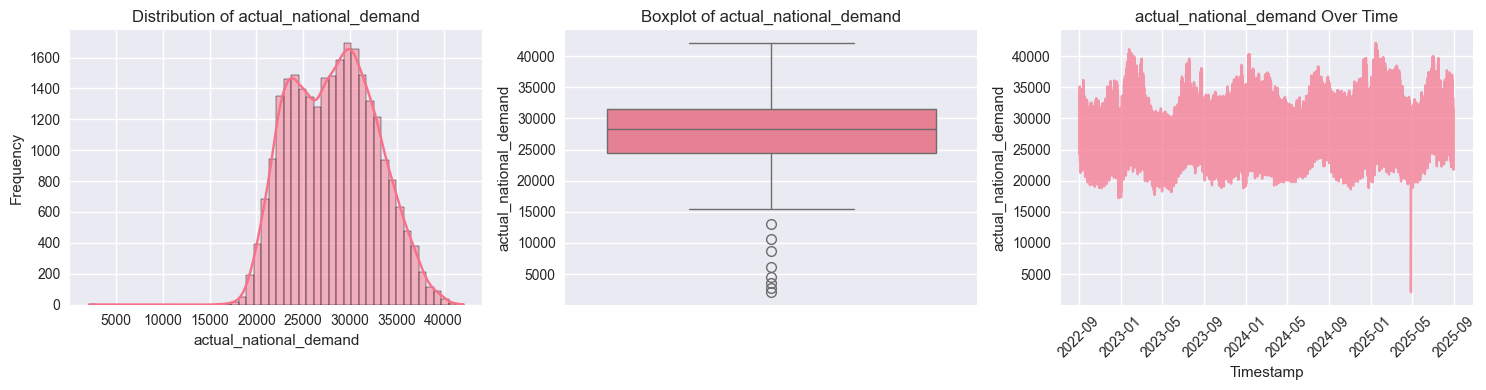


ANALYSIS FOR: dam_allocated_energy_spain
count    26289.000000
mean     20203.732276
std       4397.696556
min         80.300000
25%      16936.300000
50%      19691.300000
75%      23108.700000
max      36294.900000
Name: dam_allocated_energy_spain, dtype: float64

Additional Stats:
Skewness: 0.379
Kurtosis: -0.047
Missing values: 15
Zero values: 0 (0.00%)


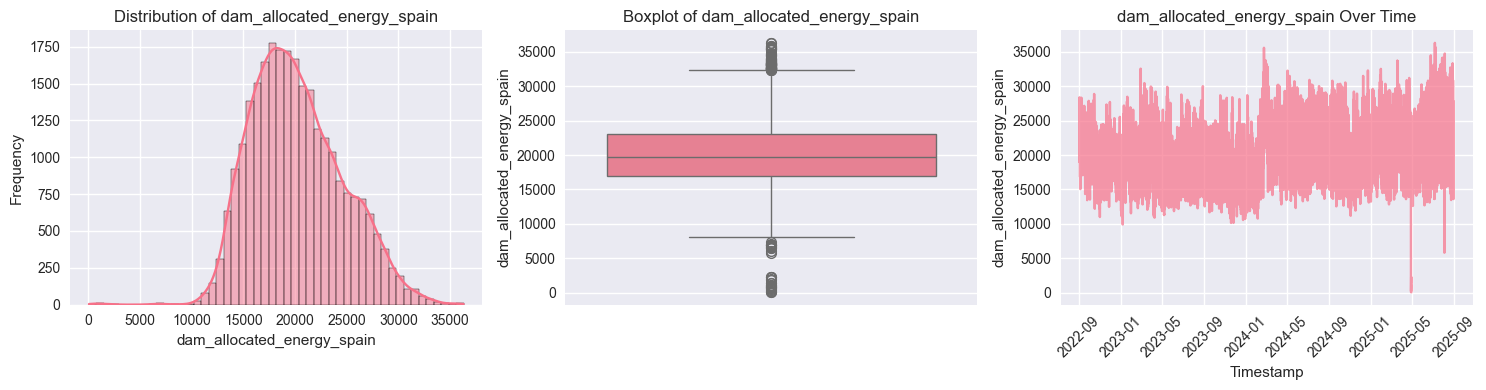


ANALYSIS FOR: scheduled_coal
count    25080.000000
mean       408.709494
std        233.956958
min         15.000000
25%        243.000000
50%        320.000000
75%        487.462500
max       1655.000000
Name: scheduled_coal, dtype: float64

Additional Stats:
Skewness: 1.969
Kurtosis: 4.700
Missing values: 1224
Zero values: 0 (0.00%)


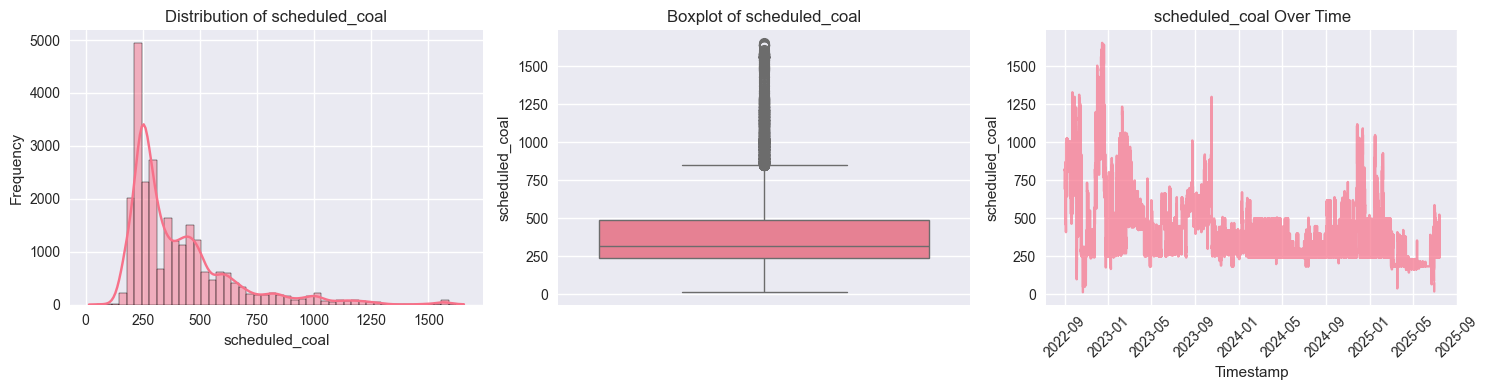


ANALYSIS FOR: scheduled_combined_cycle
count    26266.000000
mean      4206.297957
std       2994.971911
min        302.900000
25%       1981.137500
50%       3319.712500
75%       5689.350000
max      17054.625000
Name: scheduled_combined_cycle, dtype: float64

Additional Stats:
Skewness: 1.315
Kurtosis: 1.517
Missing values: 38
Zero values: 0 (0.00%)


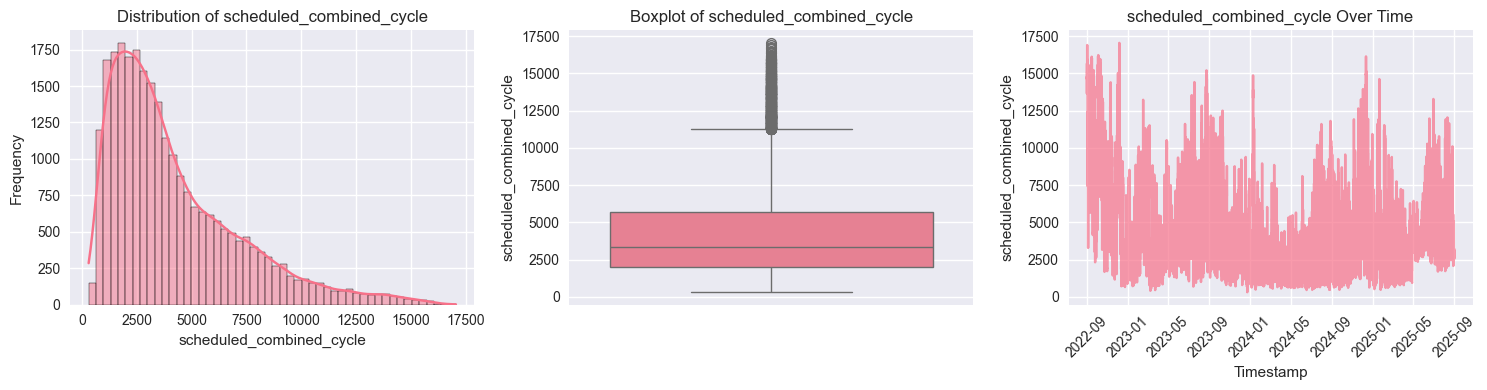


ANALYSIS FOR: scheduled_wind
count    26266.000000
mean      6879.659566
std       4083.082989
min        301.125000
25%       3602.518750
50%       6103.775000
75%       9496.906250
max      21271.000000
Name: scheduled_wind, dtype: float64

Additional Stats:
Skewness: 0.720
Kurtosis: -0.134
Missing values: 38
Zero values: 0 (0.00%)


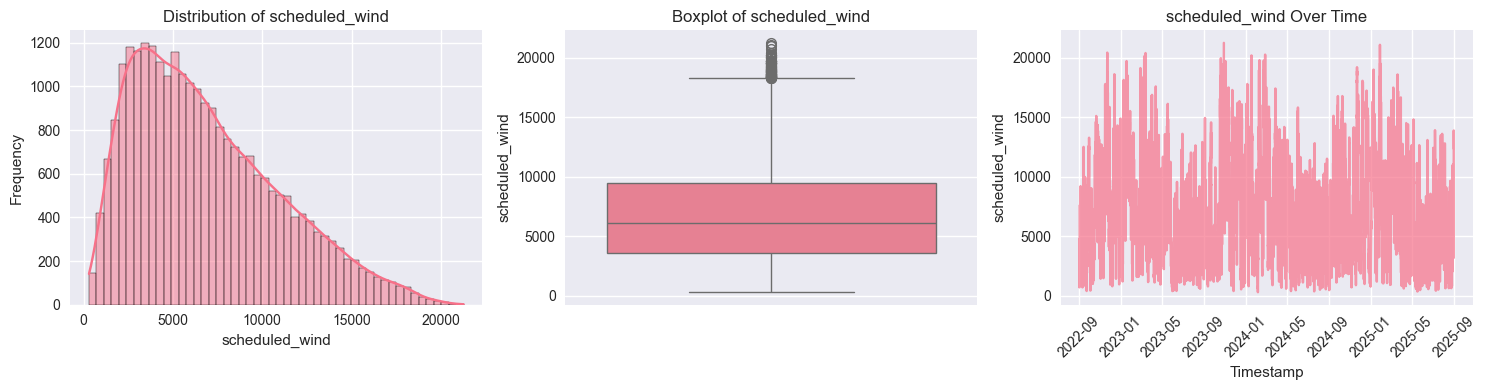


ANALYSIS FOR: scheduled_hydraulic
count    26266.000000
mean      3012.985097
std       1997.575420
min        148.125000
25%       1298.737500
50%       2624.050000
75%       4355.081250
max       9393.675000
Name: scheduled_hydraulic, dtype: float64

Additional Stats:
Skewness: 0.688
Kurtosis: -0.411
Missing values: 38
Zero values: 0 (0.00%)


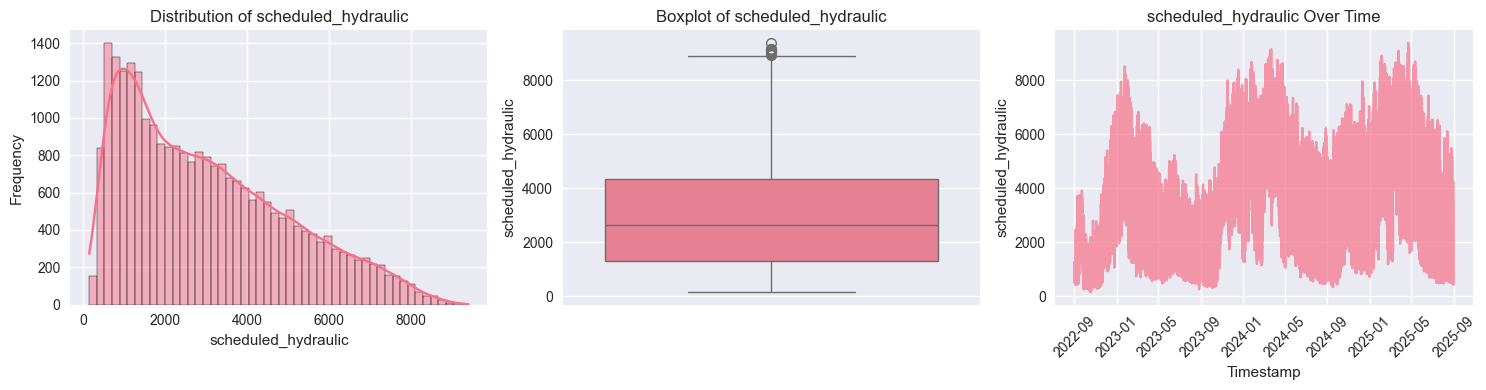


ANALYSIS FOR: scheduled_total_import
count    26178.000000
mean      1911.264616
std       1176.420914
min          0.200000
25%        888.025000
50%       1824.650000
75%       2808.000000
max       8100.325000
Name: scheduled_total_import, dtype: float64

Additional Stats:
Skewness: 0.365
Kurtosis: -0.538
Missing values: 126
Zero values: 0 (0.00%)


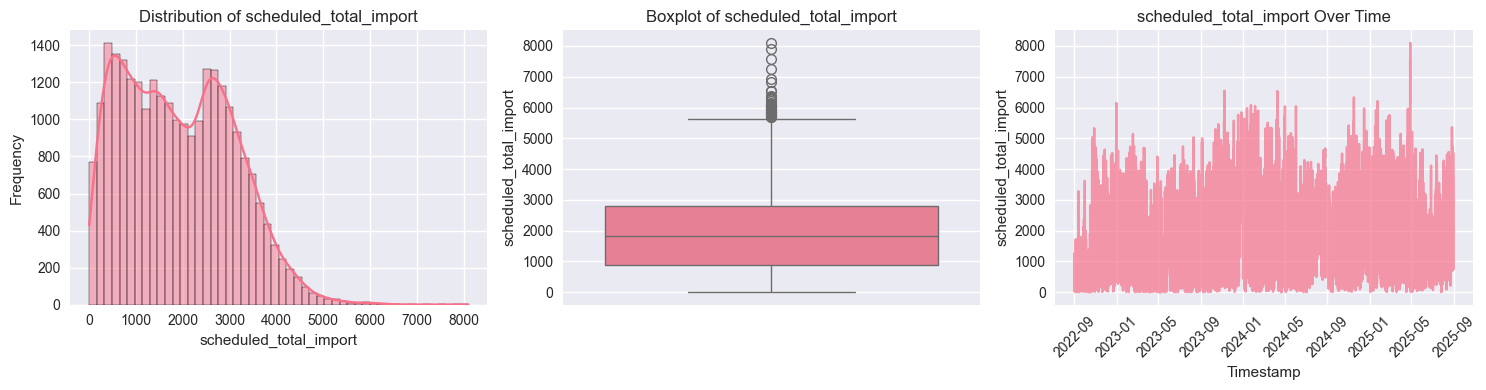


ANALYSIS FOR: scheduled_nuclear
count    26266.000000
mean      6083.731763
std       1073.778279
min        142.000000
25%       5095.000000
50%       6499.400000
75%       6945.900000
max      12101.400000
Name: scheduled_nuclear, dtype: float64

Additional Stats:
Skewness: -1.224
Kurtosis: 1.839
Missing values: 38
Zero values: 0 (0.00%)


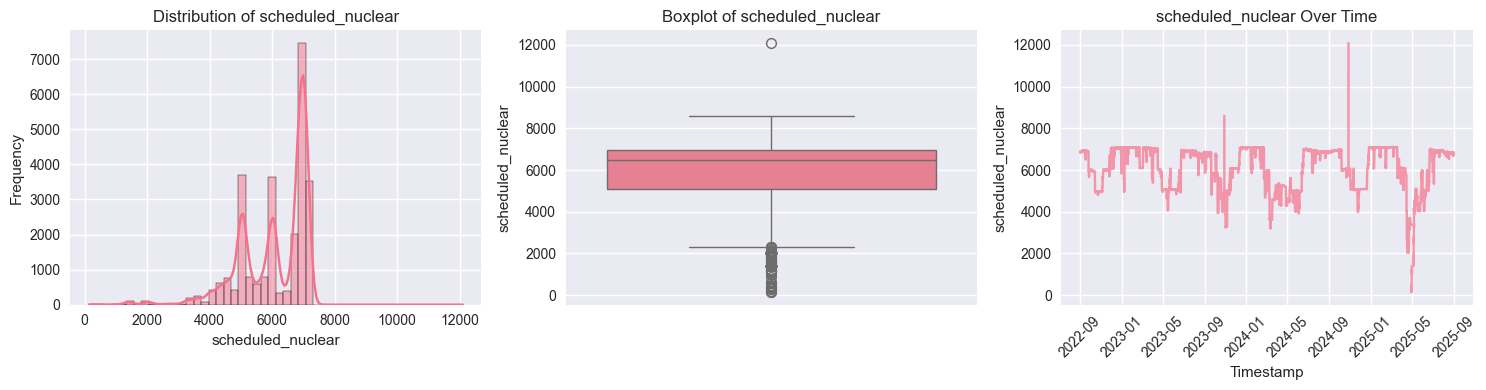


ANALYSIS FOR: scheduled_solar_pv
count    25521.000000
mean      4893.826097
std       6054.772868
min          0.025000
25%          3.600000
50%        705.100000
75%      10073.375000
max      22889.516000
Name: scheduled_solar_pv, dtype: float64

Additional Stats:
Skewness: 0.858
Kurtosis: -0.668
Missing values: 783
Zero values: 0 (0.00%)


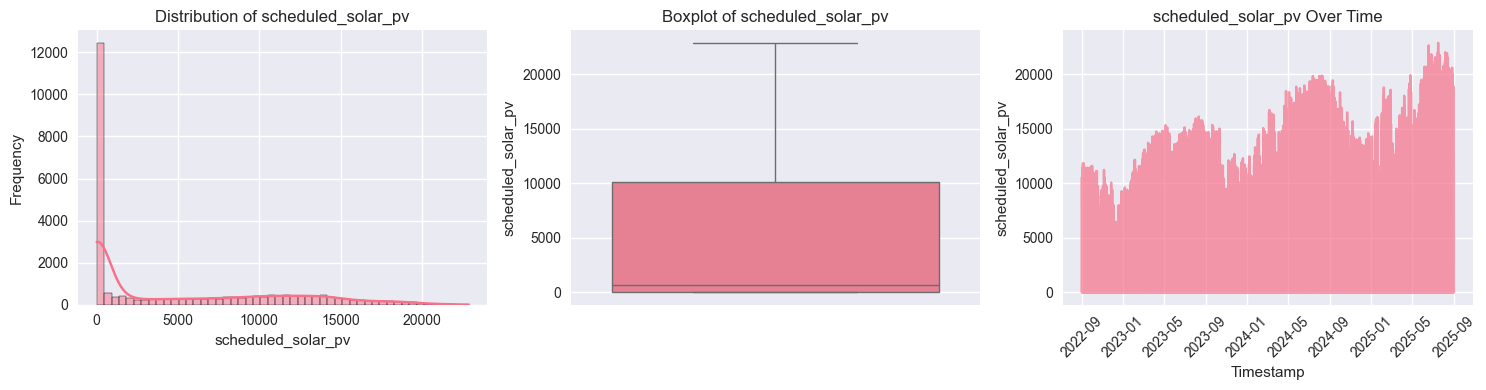


ANALYSIS FOR: actual_coal_generation
count    26302.000000
mean       390.836749
std        247.173132
min          0.000000
25%        248.916667
50%        308.083333
75%        490.895833
max       1576.250000
Name: actual_coal_generation, dtype: float64

Additional Stats:
Skewness: 1.541
Kurtosis: 3.526
Missing values: 2
Zero values: 1472 (5.60%)


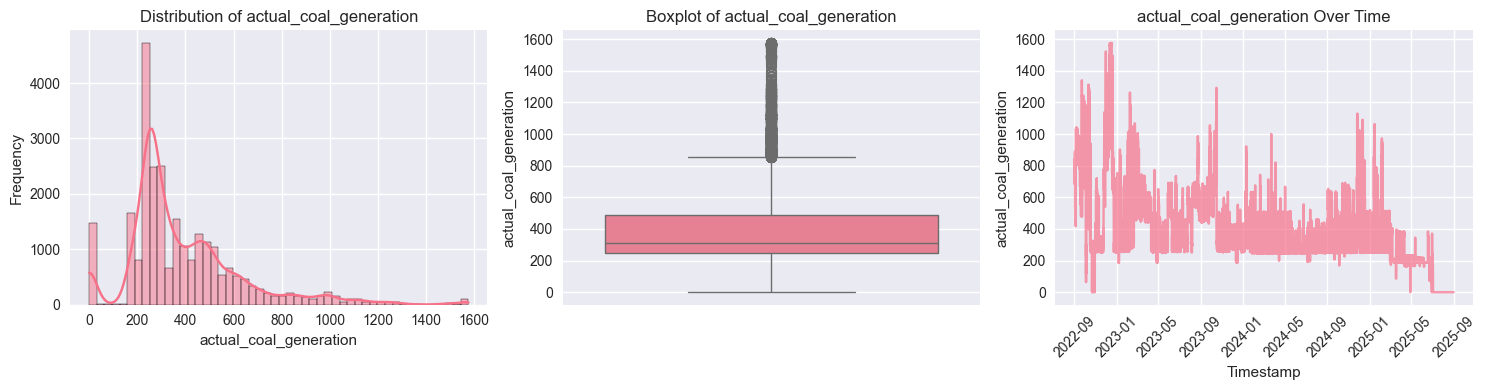


ANALYSIS FOR: actual_combined_cycle_generation
count    26221.000000
mean      5102.684035
std       3036.824465
min        672.666667
25%       2833.916667
50%       4253.916667
75%       6661.416667
max      18216.250000
Name: actual_combined_cycle_generation, dtype: float64

Additional Stats:
Skewness: 1.242
Kurtosis: 1.310
Missing values: 83
Zero values: 0 (0.00%)


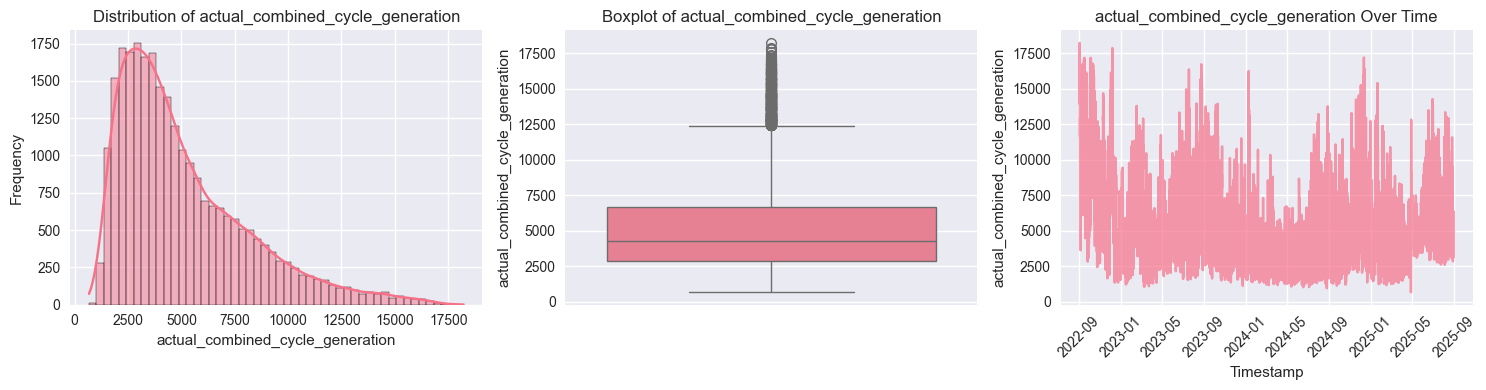


ANALYSIS FOR: actual_wind_generation
count    26221.000000
mean      6885.146076
std       4007.116740
min         80.083333
25%       3669.333333
50%       6179.166667
75%       9461.083333
max      20908.166667
Name: actual_wind_generation, dtype: float64

Additional Stats:
Skewness: 0.689
Kurtosis: -0.178
Missing values: 83
Zero values: 0 (0.00%)


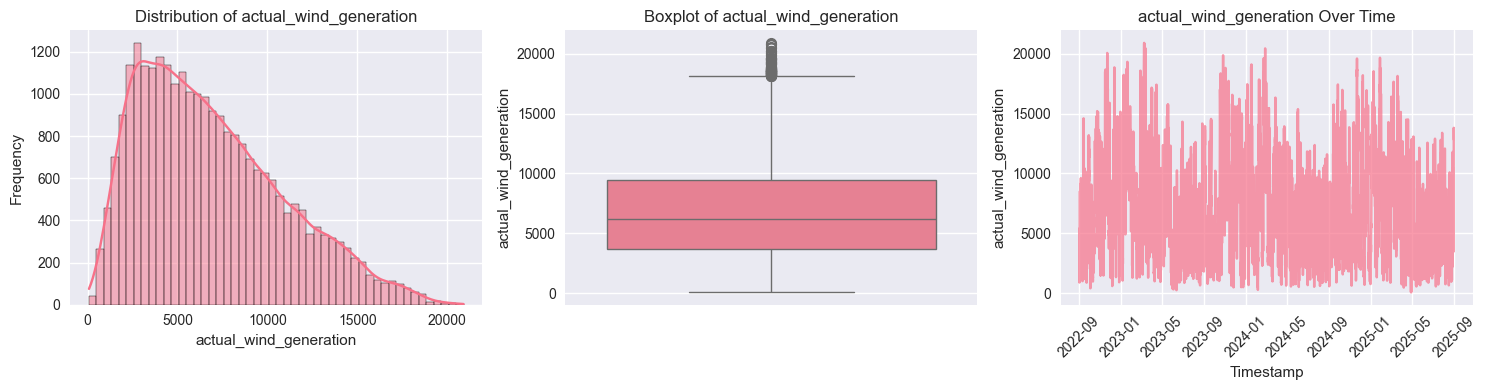


ANALYSIS FOR: actual_hydraulic_generation
count    26221.000000
mean      3109.744004
std       3082.350067
min      -3690.166667
25%        832.166667
50%       2932.500000
75%       5310.750000
max      11695.916667
Name: actual_hydraulic_generation, dtype: float64

Additional Stats:
Skewness: 0.199
Kurtosis: -0.615
Missing values: 83
Zero values: 0 (0.00%)
Negative values: 4478 (17.02%)


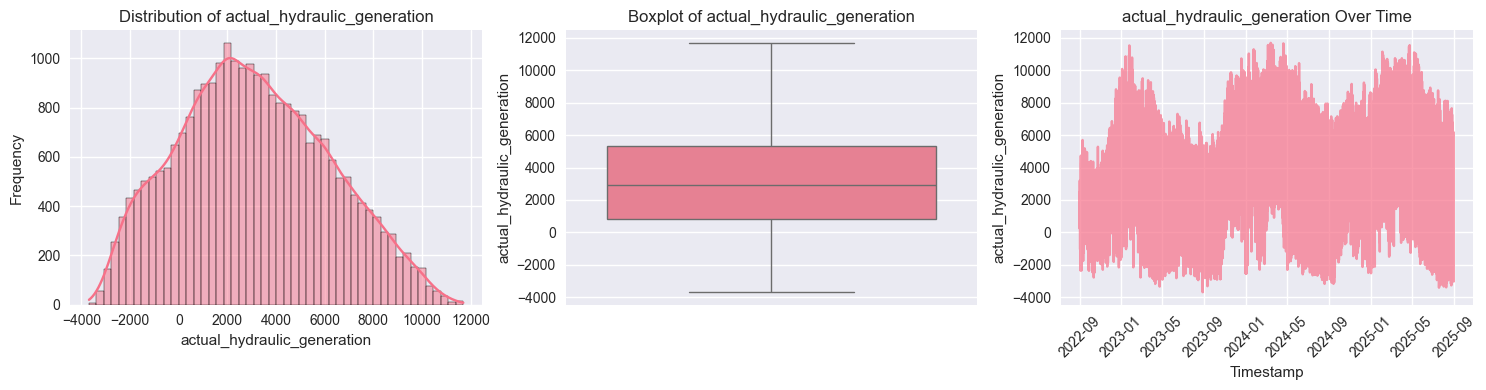


ANALYSIS FOR: actual_nuclear_generation
count    26221.000000
mean      6093.051645
std       1095.668374
min          0.000000
25%       5106.000000
50%       6490.833333
75%       6987.416667
max       7140.416667
Name: actual_nuclear_generation, dtype: float64

Additional Stats:
Skewness: -1.361
Kurtosis: 2.678
Missing values: 83
Zero values: 32 (0.12%)


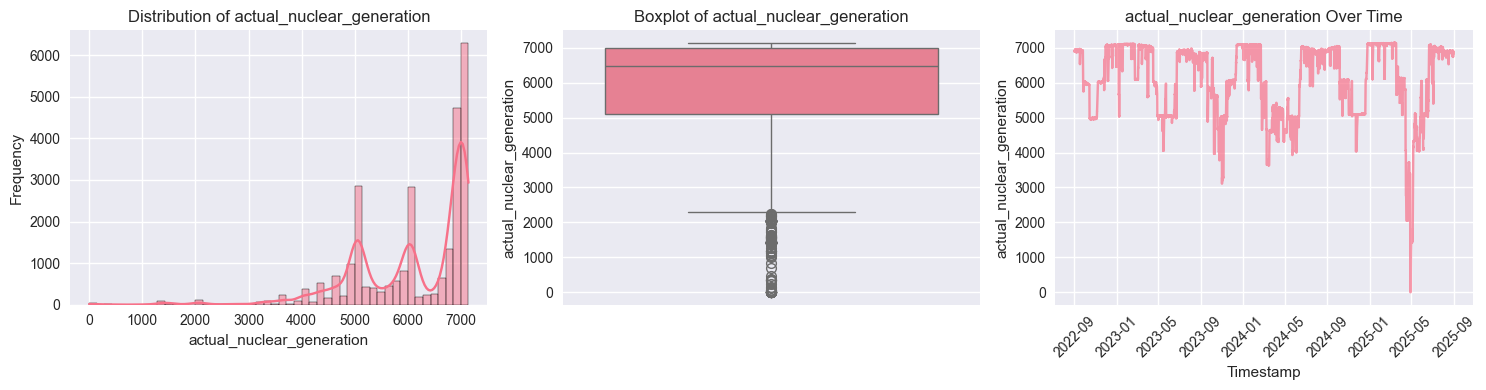


ANALYSIS FOR: actual_solar_pv_generation
count    26221.000000
mean      4685.597373
std       6003.637684
min          0.000000
25%         30.166667
50%        325.333333
75%       9678.750000
max      23220.916667
Name: actual_solar_pv_generation, dtype: float64

Additional Stats:
Skewness: 0.947
Kurtosis: -0.484
Missing values: 83
Zero values: 67 (0.25%)


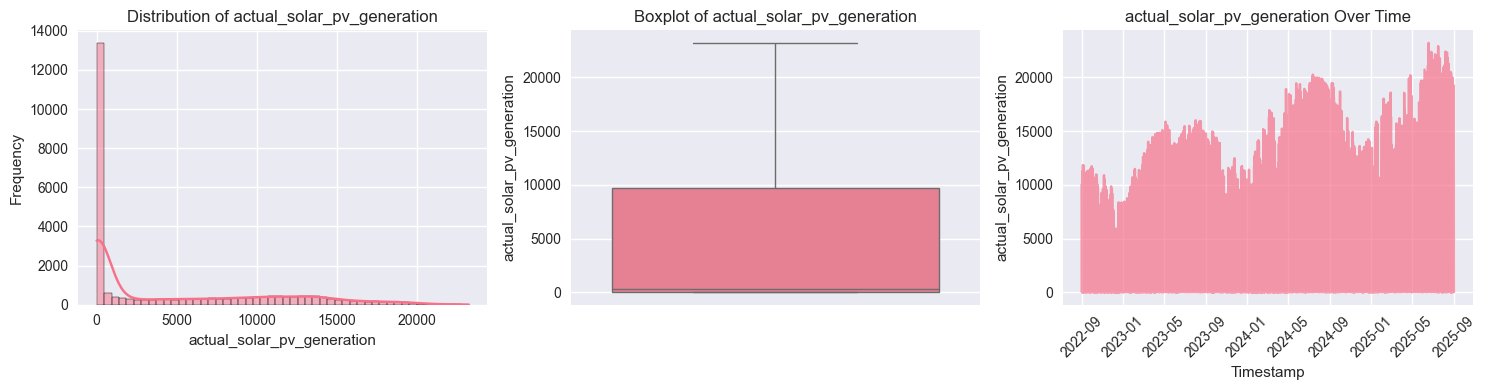


CORRELATION WITH TARGET VARIABLE (spot_price_spain)

Top variables correlated with spot_price_spain:
actual_combined_cycle_generation    | Correlation:   0.751 | Absolute:   0.751
scheduled_combined_cycle            | Correlation:   0.749 | Absolute:   0.749
scheduled_coal                      | Correlation:   0.470 | Absolute:   0.470
actual_coal_generation              | Correlation:   0.438 | Absolute:   0.438
scheduled_solar_pv                  | Correlation:  -0.397 | Absolute:   0.397
actual_solar_pv_generation          | Correlation:  -0.393 | Absolute:   0.393
dam_allocated_energy_spain          | Correlation:  -0.355 | Absolute:   0.355
actual_hydraulic_generation         | Correlation:   0.349 | Absolute:   0.349
scheduled_nuclear                   | Correlation:   0.305 | Absolute:   0.305
actual_nuclear_generation           | Correlation:   0.305 | Absolute:   0.305
scheduled_demand                    | Correlation:   0.296 | Absolute:   0.296
actual_national_demand       

In [35]:
# ---------------------------
# Basic stats & distributions for the rest of the variables 
# ---------------------------
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
all_variables = [
    'timestamp', 'scheduled_demand', 'actual_national_demand', 
    'dam_allocated_energy_spain', 'scheduled_coal', 'scheduled_combined_cycle',
    'scheduled_wind', 'scheduled_hydraulic', 'scheduled_total_import',
    'scheduled_nuclear', 'scheduled_solar_pv', 'actual_coal_generation',
    'actual_combined_cycle_generation', 'actual_wind_generation',
    'actual_hydraulic_generation', 'actual_nuclear_generation',
    'actual_solar_pv_generation', 'hour', 'day_of_week', 'month', 'spot_price_spain'
]

# numerical analysis
numerical_variables_sans_target = [var for var in all_variables if var not in ['timestamp','hour', 'day_of_week', 'month','spot_price_spain']]

for var in numerical_variables_sans_target:
    print(f"\n{'='*60}")
    print(f"ANALYSIS FOR: {var}")
    print(f"{'='*60}")
    
    # Basic
    print(Dataset[var].describe())
    
    # Additional
    print(f"\nAdditional Stats:")
    print(f"Skewness: {Dataset[var].skew():.3f}")
    print(f"Kurtosis: {Dataset[var].kurtosis():.3f}")
    print(f"Missing values: {Dataset[var].isnull().sum()}")
    print(f"Zero values: {(Dataset[var] == 0).sum()} ({(Dataset[var] == 0).mean()*100:.2f}%)")
    if Dataset[var].min() < 0:
        print(f"Negative values: {(Dataset[var] < 0).sum()} ({(Dataset[var] < 0).mean()*100:.2f}%)")
        
    
    plt.figure(figsize=(15, 4))
    
    # Distribution plot
    plt.subplot(1, 3, 1)
    sns.histplot(Dataset[var], bins=50, kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    
    # Box plot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=Dataset[var])
    plt.title(f'Boxplot of {var}')
    plt.ylabel(var)
    
    # Time series 
    plt.subplot(1, 3, 3)
    plt.plot(Dataset['timestamp'], Dataset[var], alpha=0.7)
    plt.title(f'{var} Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel(var)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Correlation analysis with target variable
print("\n" + "="*80)
print("CORRELATION WITH TARGET VARIABLE (spot_price_spain)")
print("="*80)

# Calculate correlations
correlations = []
for var in numerical_variables_sans_target:
        corr = Dataset[var].corr(Dataset['spot_price_spain'])
        correlations.append((var, corr, abs(corr)))

# Sort by absolute correlation
correlations.sort(key=lambda x: x[2], reverse=True)

print("\nTop variables correlated with spot_price_spain:")
for var, corr, abs_corr in correlations[:15]:
    print(f"{var:35} | Correlation: {corr:7.3f} | Absolute: {abs_corr:7.3f}")

print("\nBottom variables correlated with spot_price_spain:")
for var, corr, abs_corr in correlations[-10:]:
    print(f"{var:35} | Correlation: {corr:7.3f} | Absolute: {abs_corr:7.3f}")

In [36]:
from IPython.display import Markdown

Markdown("""


## **Missing Values Problem**

- **scheduled_coal:** 1,224 missing values (4.65% )  
- **scheduled_solar_pv:** 783 missing values (2.98%)  
- **actual_national_demand:** 83 missing values  
- **Other variables:** 2–126 missing values  

---

## **Anomalies**

- **scheduled_demand:** 35 zeros + 2 missing →    
- **actual_coal_generation:** 1,472 zeros _(5.6%)_
- **actual_nuclear_generation:** 32 zeros, unusual 
- **scheduled_demand min = 0** 


## Price Drivers
- **Combined cycle:** +0.75  
- **Coal:** +0.47  

## Renewables Push Prices Down 
- **Solar PV:** -0.39  
- **Wind:** -0.24  

## Nuclear - Runs during high-price periods → base-load + price-taker behavior

## Demand: Correlation only **0.28–0.30**, inelastic 


- Combined cycle = price setter, high correlation 
- Coal influences price when operating at margin  
- **Renewables depresses prices**  
""")





## **Missing Values Problem**

- **scheduled_coal:** 1,224 missing values (4.65% )  
- **scheduled_solar_pv:** 783 missing values (2.98%)  
- **actual_national_demand:** 83 missing values  
- **Other variables:** 2–126 missing values  

---

## **Anomalies**

- **scheduled_demand:** 35 zeros + 2 missing →    
- **actual_coal_generation:** 1,472 zeros _(5.6%)_
- **actual_nuclear_generation:** 32 zeros, unusual 
- **scheduled_demand min = 0** 


## Price Drivers
- **Combined cycle:** +0.75  
- **Coal:** +0.47  

## Renewables Push Prices Down 
- **Solar PV:** -0.39  
- **Wind:** -0.24  

## Nuclear - Runs during high-price periods → base-load + price-taker behavior

## Demand: Correlation only **0.28–0.30**, inelastic 


- Combined cycle = price setter, high correlation 
- Coal influences price when operating at margin  
- **Renewables depresses prices**  


In [37]:
# Dealing with missing values ???

Original dataset size: 26304
Clean dataset size (without price outliers): 26253
Price outliers removed: 51 (0.19%)


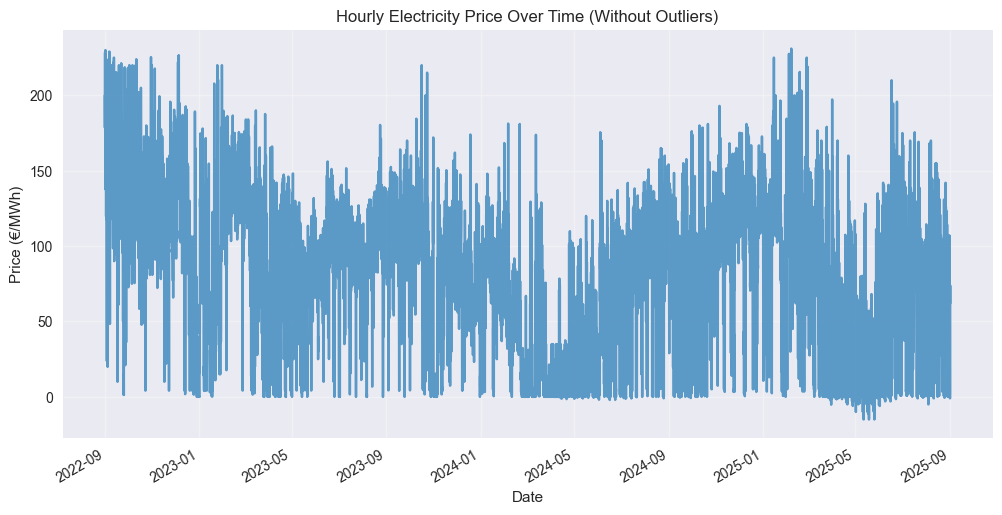

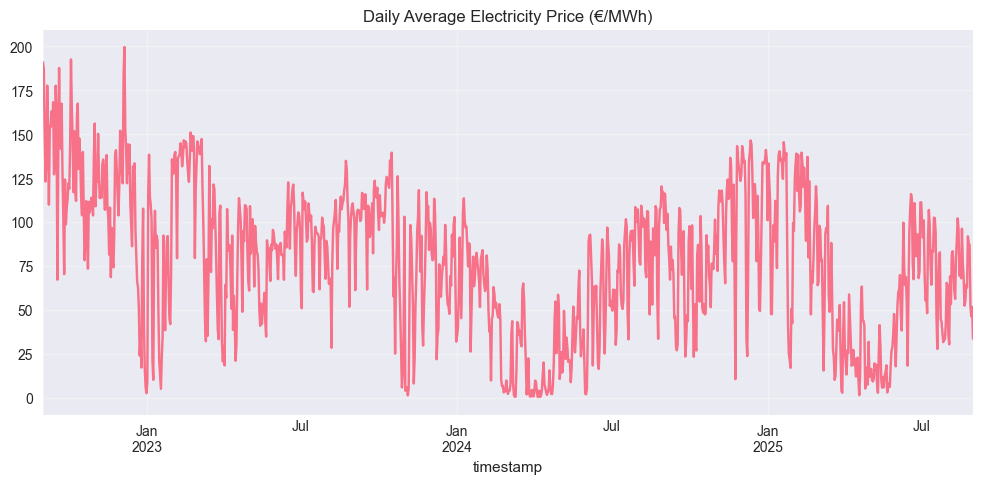

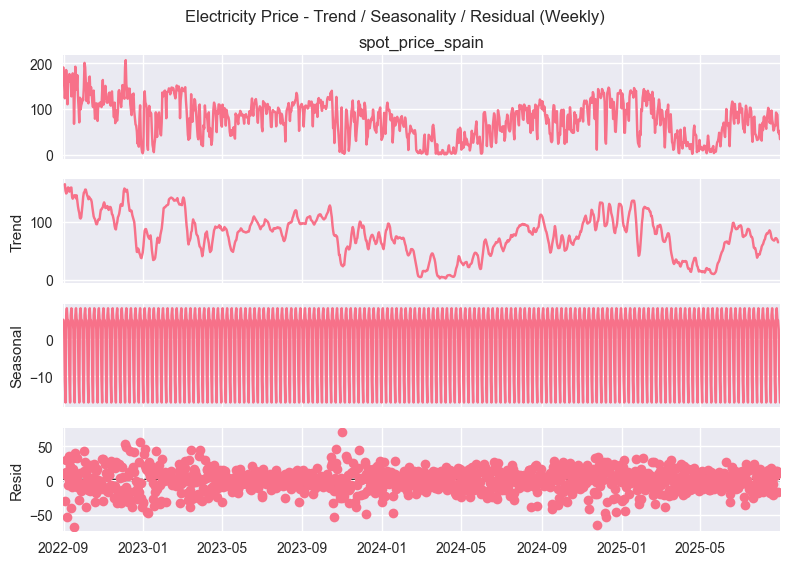

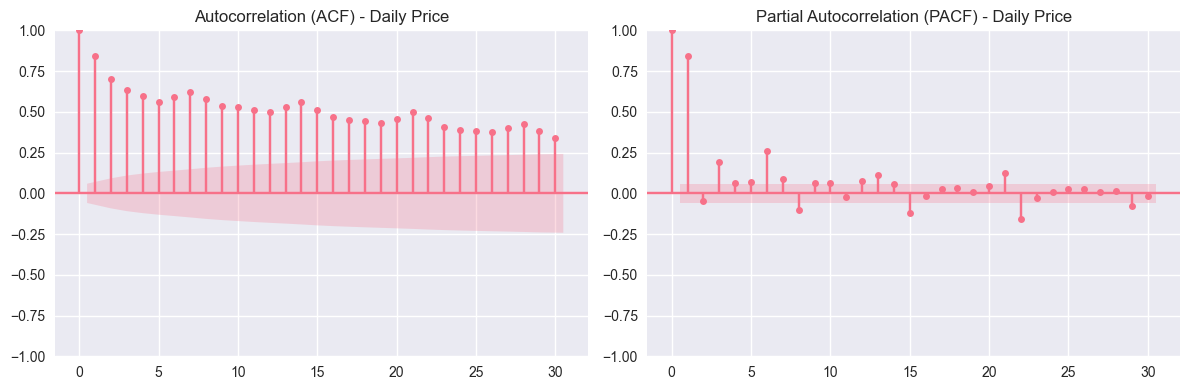

NA timestamp: 0 Duplicates: 0
Missing hours: 0


C:\Users\davide\AppData\Local\Temp\ipykernel_676\782228652.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(Dataset_indexed.index.min(),


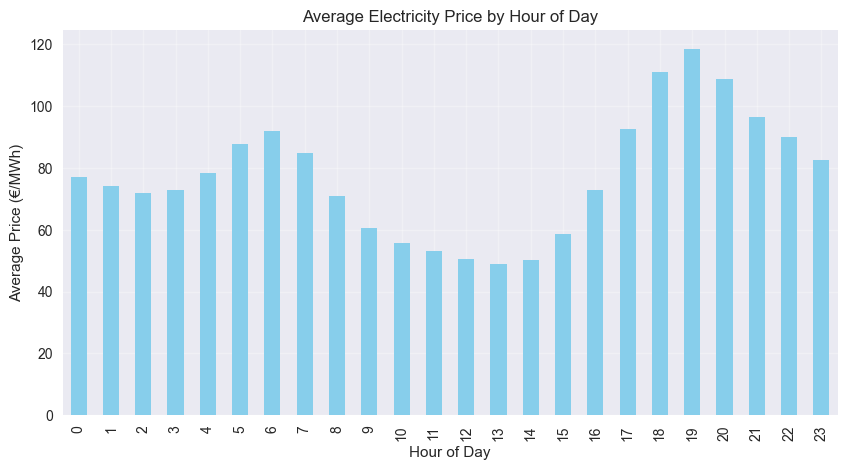

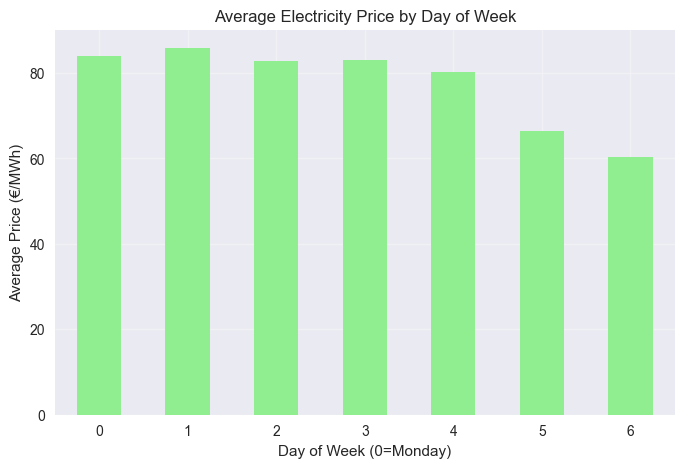

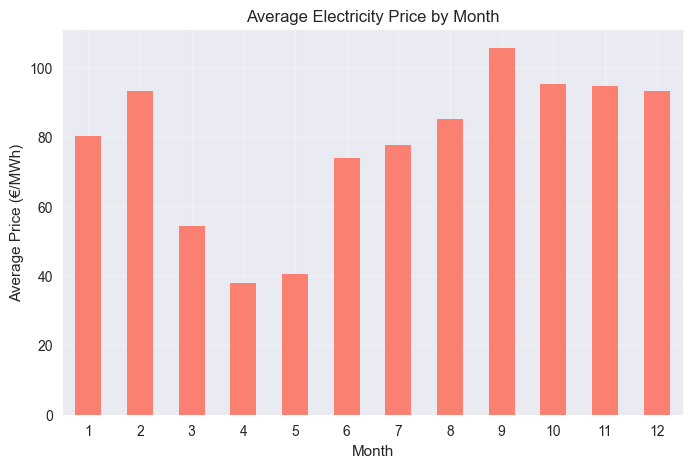

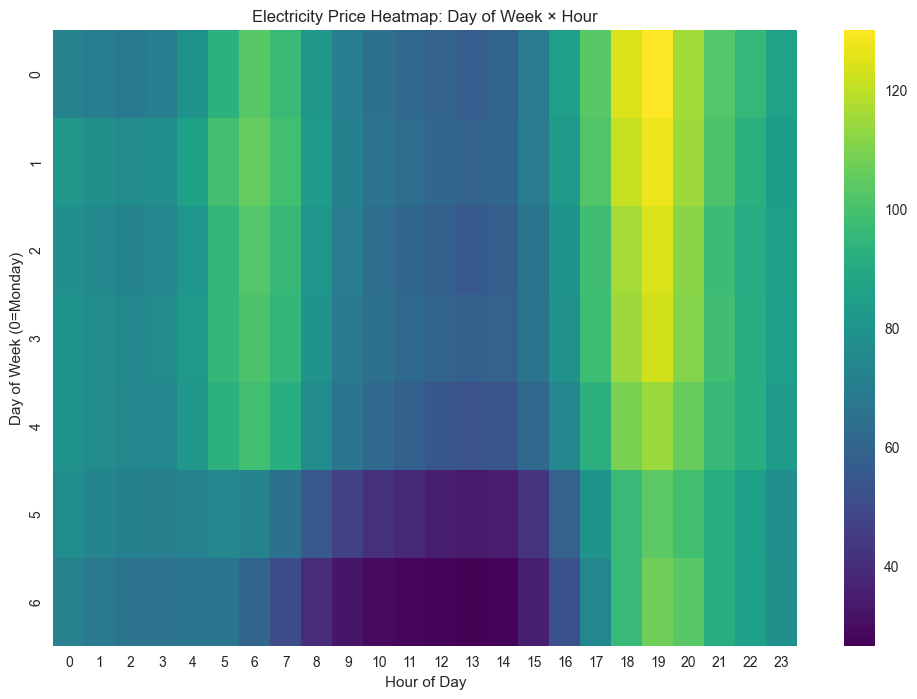

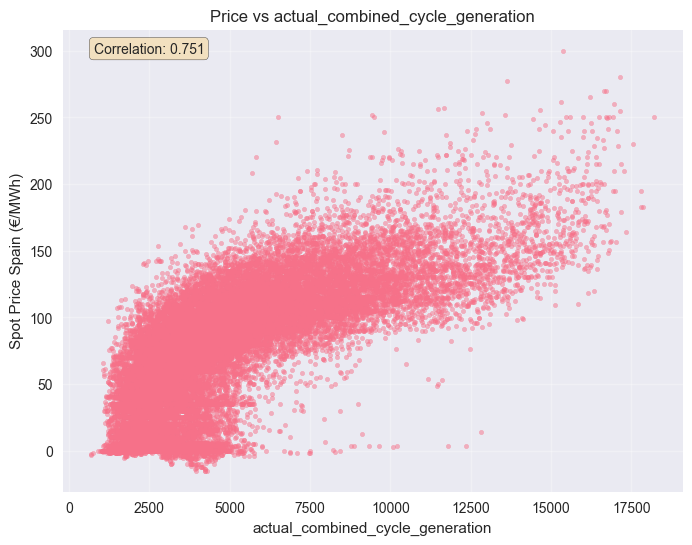

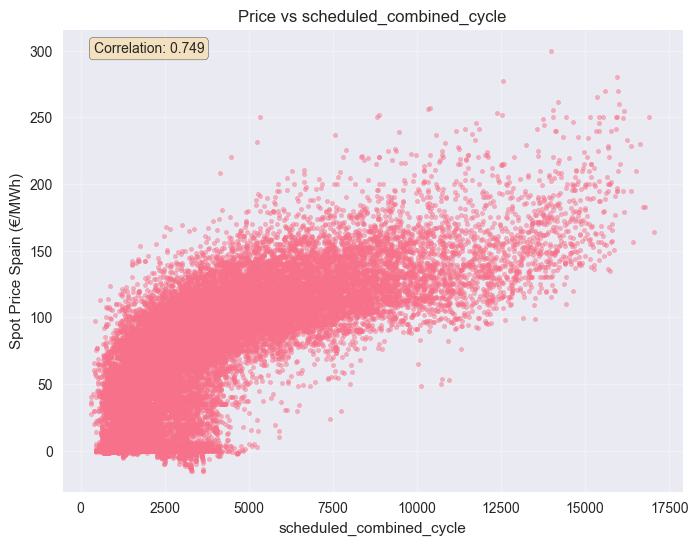

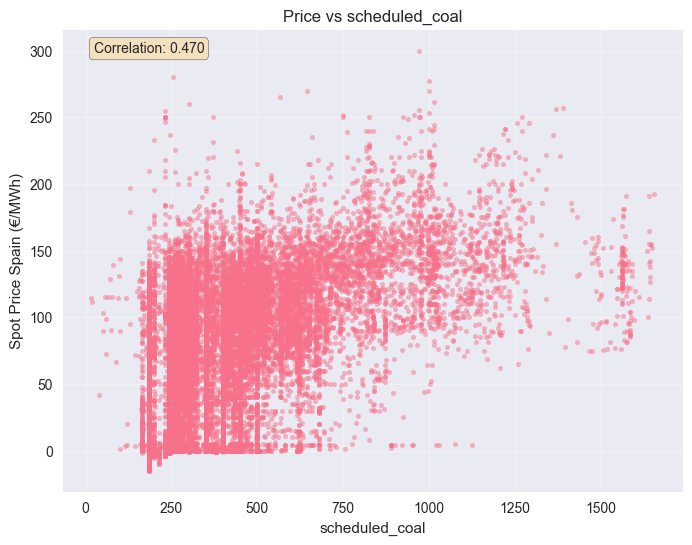

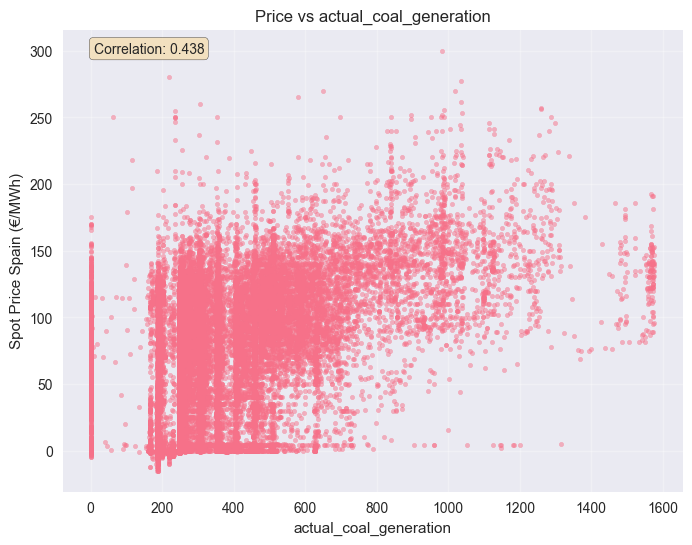

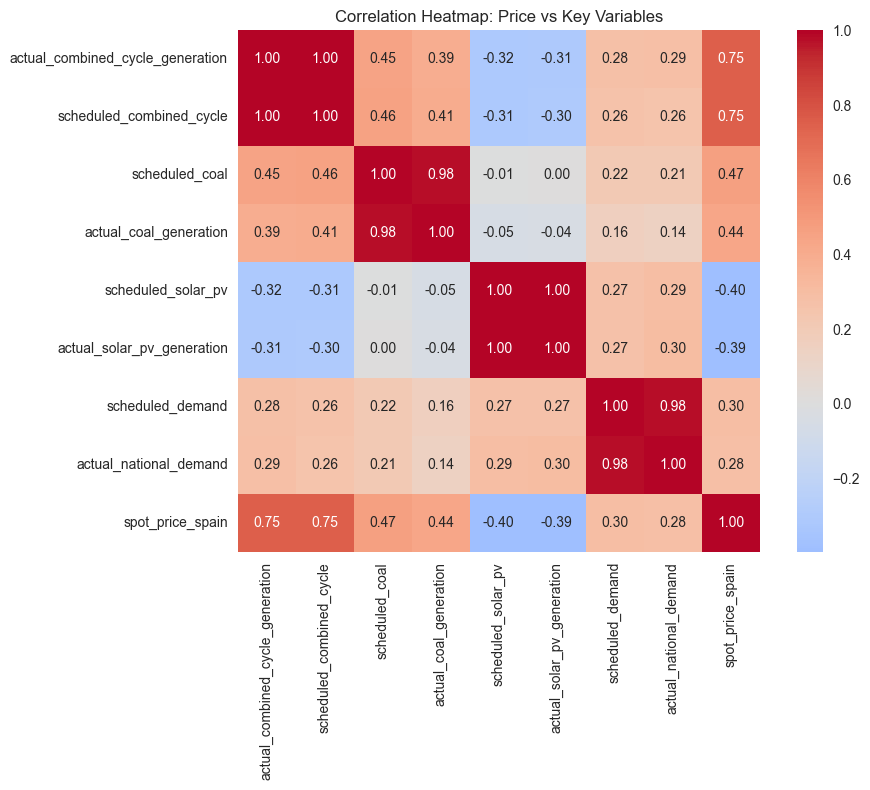

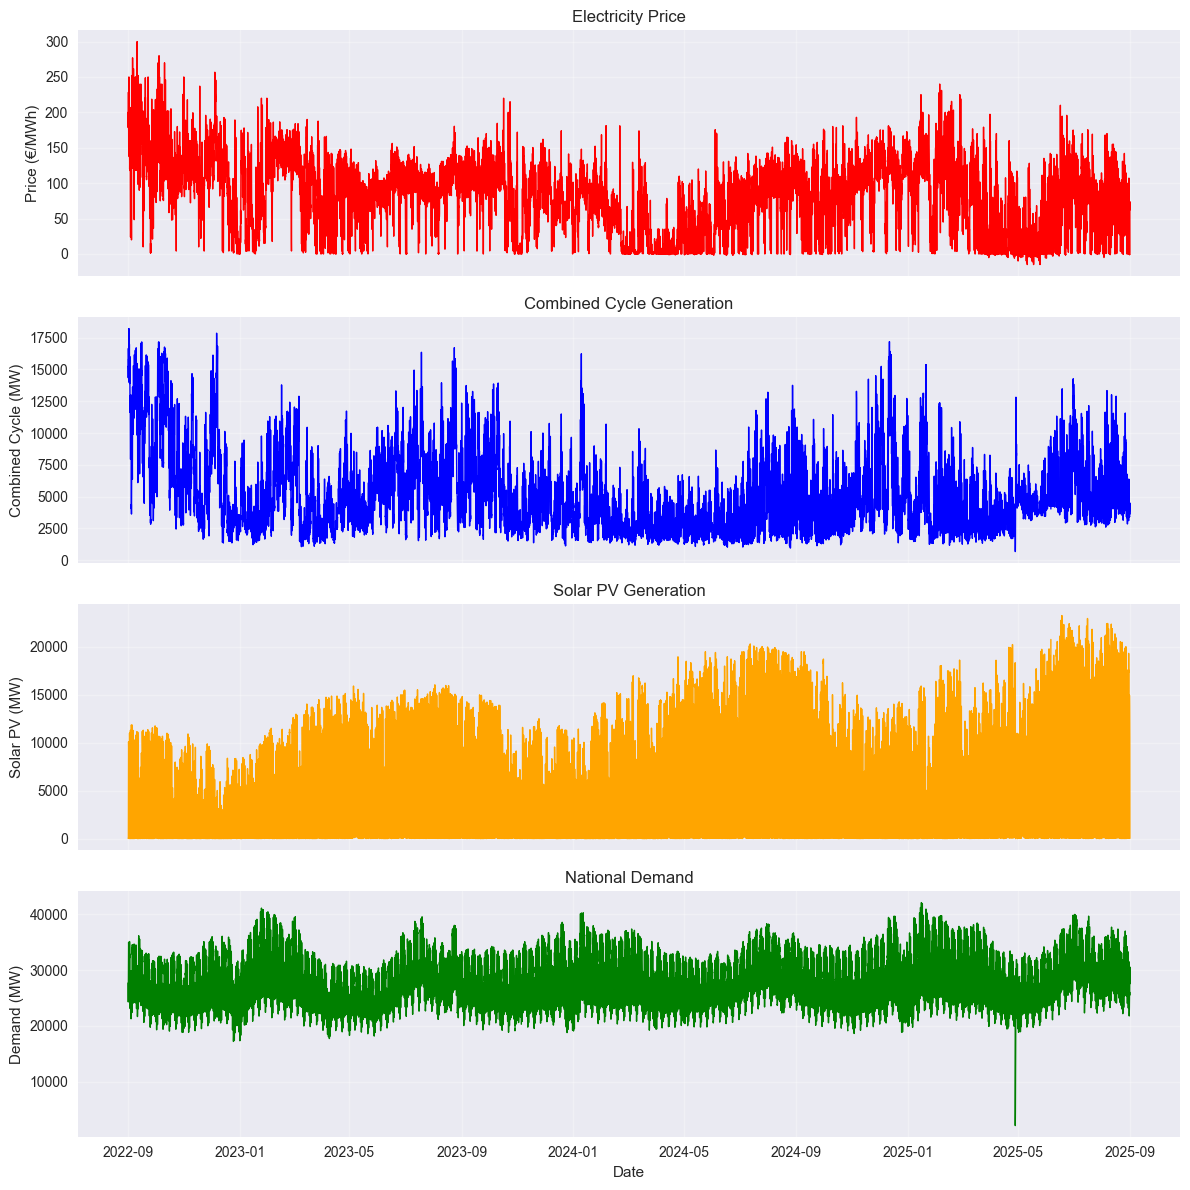

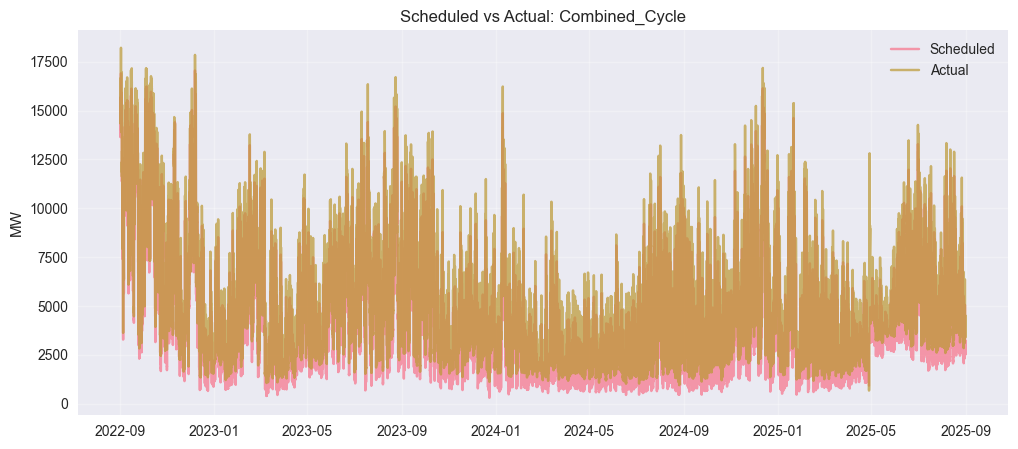

scheduled_combined_cycle vs actual_combined_cycle_generation:
  Mean Error: 889.66 MW
  Std Error: 302.56 MW
  Correlation: 0.995



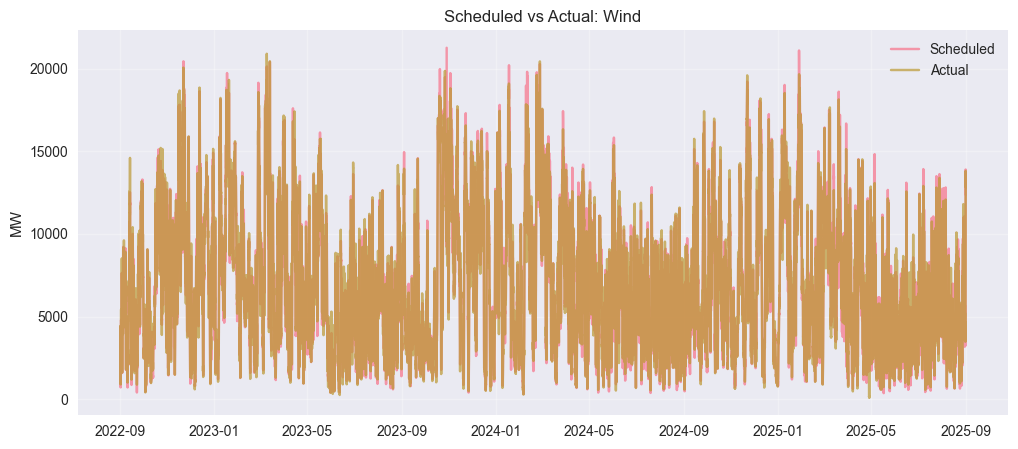

scheduled_wind vs actual_wind_generation:
  Mean Error: 18.57 MW
  Std Error: 590.67 MW
  Correlation: 0.990



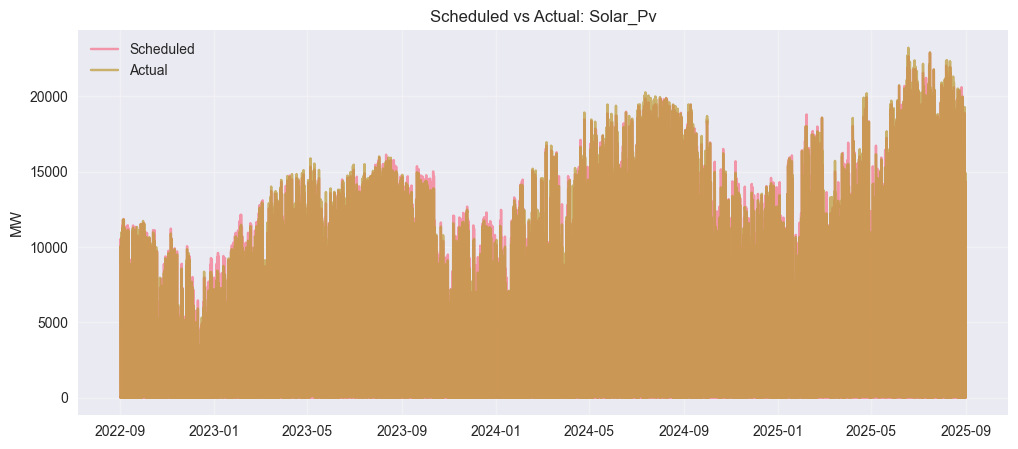

scheduled_solar_pv vs actual_solar_pv_generation:
  Mean Error: -66.88 MW
  Std Error: 479.92 MW
  Correlation: 0.997



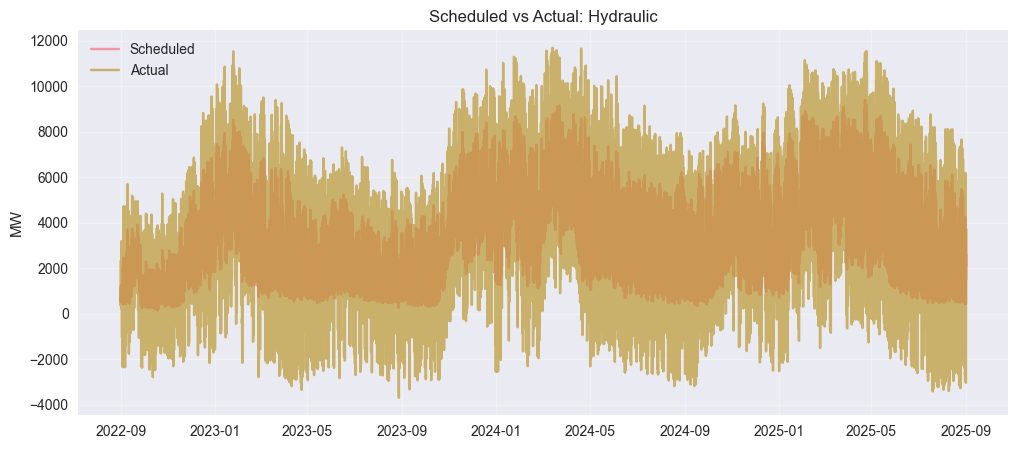

scheduled_hydraulic vs actual_hydraulic_generation:
  Mean Error: 92.96 MW
  Std Error: 1520.23 MW
  Correlation: 0.908

Lag features preview:
                     spot_price_spain  price_t-24  price_t-72  price_t-168  \
timestamp                                                                    
2022-08-31 22:00:00            200.00         NaN         NaN          NaN   
2022-08-31 23:00:00            181.99         NaN         NaN          NaN   
2022-09-01 00:00:00            178.54         NaN         NaN          NaN   
2022-09-01 01:00:00            178.54         NaN         NaN          NaN   
2022-09-01 02:00:00            181.23         NaN         NaN          NaN   
2022-09-01 03:00:00            189.65         NaN         NaN          NaN   
2022-09-01 04:00:00            198.64         NaN         NaN          NaN   
2022-09-01 05:00:00            227.31         NaN         NaN          NaN   
2022-09-01 06:00:00            228.40         NaN         NaN          NaN   

In [38]:
# ---------------------------
# Outlier filter (IQR) for EDA plots only (do not alter original)
# ---------------------------
def remove_outliers_iqr(df, col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# target variable clean visualization
clean_price = remove_outliers_iqr(Dataset, 'spot_price_spain').copy()
clean_price = clean_price.set_index('timestamp').sort_index()

print(f"Original dataset size: {len(Dataset)}")
print(f"Clean dataset size (without price outliers): {len(clean_price)}")
print(f"Price outliers removed: {len(Dataset) - len(clean_price)} ({(len(Dataset) - len(clean_price)) / len(Dataset) * 100:.2f}%)")

# ---------------------------
# Time series plots (hourly, daily mean)
# ---------------------------
plt.figure(figsize=(12,6))
clean_price['spot_price_spain'].plot(color='tab:blue', alpha=0.7)
plt.title('Hourly Electricity Price Over Time (Without Outliers)')
plt.xlabel('Date'); plt.ylabel('Price (€/MWh)')
plt.grid(True, alpha=0.3)
plt.show()

# Daily average price
daily_price = clean_price['spot_price_spain'].resample('D').mean().dropna()
daily_price.plot(figsize=(12,5), title='Daily Average Electricity Price (€/MWh)')
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------
# Seasonal decomposition + ACF/PACF
# ---------------------------
# Use original data for decomposition to preserve seasonality
daily_original = Dataset.set_index('timestamp')['spot_price_spain'].resample('D').mean().dropna()
decomp = seasonal_decompose(daily_original, period=7, model='additive')  # Weekly
decomp.plot()
plt.suptitle('Electricity Price - Trend / Seasonality / Residual (Weekly)', y=1.02)
plt.show()

# ACF and PACF plots
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plot_acf(daily_original, lags=30, ax=plt.gca())
plt.title('Autocorrelation (ACF) - Daily Price')

plt.subplot(1,2,2)
plot_pacf(daily_original, lags=30, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation (PACF) - Daily Price')

plt.tight_layout()
plt.show()

# ---------------------------
# Data quality: gaps & duplicates
# ---------------------------
Dataset_indexed = Dataset.set_index('timestamp').sort_index()

missing_dt = Dataset['timestamp'].isna().sum()
dup_dt = Dataset.duplicated('timestamp').sum()
print("NA timestamp:", missing_dt, "Duplicates:", dup_dt)

# Check for missing hours
full_idx = pd.date_range(Dataset_indexed.index.min(),
                         Dataset_indexed.index.max(), freq='H')
gap_idx = full_idx.difference(Dataset_indexed.index)
print("Missing hours:", len(gap_idx))

if len(gap_idx) > 0:
    print("First 10 missing timestamps:")
    print(gap_idx[:10])

# ---------------------------
# 1Hour/DOW/Month profiles + heatmap
# ---------------------------
prof = Dataset_indexed.copy()
prof['Hour'] = prof.index.hour
prof['DOW'] = prof.index.dayofweek  # 0=Mon ... 6=Sun
prof['Month'] = prof.index.month

# Hourly profile
hour_profile = prof.groupby('Hour')['spot_price_spain'].mean()
plt.figure(figsize=(10,5))
hour_profile.plot(kind='bar', color='skyblue')
plt.title('Average Electricity Price by Hour of Day')
plt.xlabel('Hour of Day'); plt.ylabel('Average Price (€/MWh)')
plt.grid(True, alpha=0.3)
plt.show()

# Day of week profile
dow_profile = prof.groupby('DOW')['spot_price_spain'].mean()
plt.figure(figsize=(8,5))
dow_profile.plot(kind='bar', color='lightgreen')
plt.title('Average Electricity Price by Day of Week')
plt.xlabel('Day of Week (0=Monday)'); plt.ylabel('Average Price (€/MWh)')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

# Monthly profile
month_profile = prof.groupby('Month')['spot_price_spain'].mean()
plt.figure(figsize=(8,5))
month_profile.plot(kind='bar', color='salmon')
plt.title('Average Electricity Price by Month')
plt.xlabel('Month'); plt.ylabel('Average Price (€/MWh)')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

# Heatmap: Day of Week vs Hour
heatmap_data = prof.groupby(['DOW', 'Hour'])['spot_price_spain'].mean().unstack()
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='viridis', annot=False)
plt.title('Electricity Price Heatmap: Day of Week × Hour')
plt.xlabel('Hour of Day'); plt.ylabel('Day of Week (0=Monday)')
plt.show()

# ---------------------------
# Price vs Key Variables Analysis
# ---------------------------
# Top correlated variables
top_correlated_vars = ['actual_combined_cycle_generation', 'scheduled_combined_cycle', 
                       'scheduled_coal', 'actual_coal_generation', 'scheduled_solar_pv',
                       'actual_solar_pv_generation', 'scheduled_demand', 'actual_national_demand']


for var in top_correlated_vars[:4]:  # Plot first 4
    plt.figure(figsize=(8,6))
    plt.scatter(Dataset[var], Dataset['spot_price_spain'], alpha=0.5, s=10)
    plt.xlabel(var)
    plt.ylabel('Spot Price Spain (€/MWh)')
    plt.title(f'Price vs {var}')
    plt.grid(True, alpha=0.3)
    
   
    corr = Dataset[var].corr(Dataset['spot_price_spain'])
    plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    plt.show()

# Correlation heatmap 
top_vars_heatmap = top_correlated_vars + ['spot_price_spain']
corr_matrix = Dataset[top_vars_heatmap].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Correlation Heatmap: Price vs Key Variables')
plt.tight_layout()
plt.show()

# Parallel time series: Price vs Top 3 variables
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Price
axes[0].plot(Dataset_indexed.index, Dataset_indexed['spot_price_spain'], color='red', linewidth=1)
axes[0].set_ylabel('Price (€/MWh)')
axes[0].set_title('Electricity Price')
axes[0].grid(True, alpha=0.3)

# Combined Cycle Generation
axes[1].plot(Dataset_indexed.index, Dataset_indexed['actual_combined_cycle_generation'], color='blue', linewidth=1)
axes[1].set_ylabel('Combined Cycle (MW)')
axes[1].set_title('Combined Cycle Generation')
axes[1].grid(True, alpha=0.3)

# Solar PV Generation
axes[2].plot(Dataset_indexed.index, Dataset_indexed['actual_solar_pv_generation'], color='orange', linewidth=1)
axes[2].set_ylabel('Solar PV (MW)')
axes[2].set_title('Solar PV Generation')
axes[2].grid(True, alpha=0.3)

# Demand
axes[3].plot(Dataset_indexed.index, Dataset_indexed['actual_national_demand'], color='green', linewidth=1)
axes[3].set_ylabel('Demand (MW)')
axes[3].set_title('National Demand')
axes[3].grid(True, alpha=0.3)
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

# ---------------------------
# Compare Scheduled vs Actual Generation
# ---------------------------
# For key generation types
comparison_vars = [
    ('scheduled_combined_cycle', 'actual_combined_cycle_generation'),
    ('scheduled_wind', 'actual_wind_generation'),
    ('scheduled_solar_pv', 'actual_solar_pv_generation'),
    ('scheduled_hydraulic', 'actual_hydraulic_generation')
]

for scheduled, actual in comparison_vars:
    plt.figure(figsize=(12,5))
    plt.plot(Dataset_indexed.index, Dataset_indexed[scheduled], label=f'Scheduled', alpha=0.7)
    plt.plot(Dataset_indexed.index, Dataset_indexed[actual], label=f'Actual', alpha=0.7)
    plt.title(f'Scheduled vs Actual: {scheduled.replace("scheduled_", "").title()}')
    plt.ylabel('MW')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate forecast error
    if scheduled in Dataset.columns and actual in Dataset.columns:
        error = Dataset[actual] - Dataset[scheduled]
        print(f"{scheduled} vs {actual}:")
        print(f"  Mean Error: {error.mean():.2f} MW")
        print(f"  Std Error: {error.std():.2f} MW")
        print(f"  Correlation: {Dataset[scheduled].corr(Dataset[actual]):.3f}\n")

# ---------------------------
# Lag features
# ---------------------------
Dataset_lag = Dataset_indexed.copy()
Dataset_lag['price_t-24'] = Dataset_lag['spot_price_spain'].shift(24)  # 1 day lag
Dataset_lag['price_t-72'] = Dataset_lag['spot_price_spain'].shift(72)  # 3 days lag
Dataset_lag['price_t-168'] = Dataset_lag['spot_price_spain'].shift(168)  # 1 week lag
Dataset_lag['price_t-336'] = Dataset_lag['spot_price_spain'].shift(336)  # 2 weeks lag

Dataset_lag['demand_t-24'] = Dataset_lag['actual_national_demand'].shift(24)  # 1 day lag
Dataset_lag['demand_t-72'] = Dataset_lag['actual_national_demand'].shift(72)  # 3 days lag
Dataset_lag['demand_t-168'] = Dataset_lag['actual_national_demand'].shift(168)  # 1 week lag
Dataset_lag['demand_t-336'] = Dataset_lag['actual_national_demand'].shift(336)  # 2 weeks lag

print("Lag features preview:")
print(Dataset_lag[['spot_price_spain', 'price_t-24', 'price_t-72', 'price_t-168', 'price_t-336', 'actual_national_demand', 'demand_t-24','demand_t-72', 'demand_t-168', 'demand_t-336']].head(48))

# Correlation of lagged prices with current price
lag_correlations = Dataset_lag[['spot_price_spain', 'price_t-24', 'price_t-72', 'price_t-168', 'price_t-336']].corr()
print("\nCorrelation of lagged prices with current price:")
print(lag_correlations['spot_price_spain'].sort_values(ascending=False))


Dataset time range: 2022-08-31 22:00:00 to 2025-08-31 21:00:00


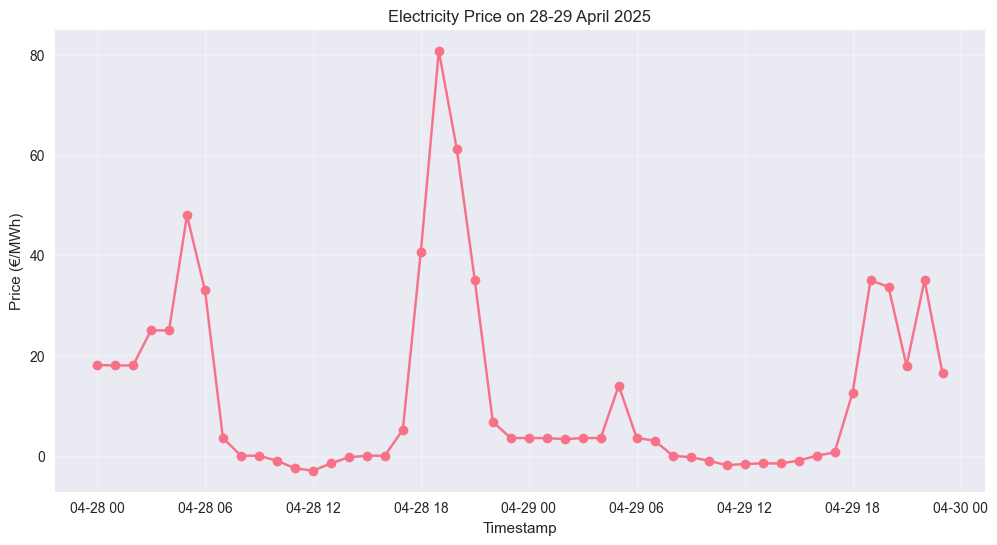

In [39]:
# start end of dataset
start_date = Dataset_indexed.index.min()
end_date = Dataset_indexed.index.max()
print(f"\nDataset time range: {start_date} to {end_date}")


# analysis of 28-29 april 2025
mask_april = (Dataset_indexed.index >= '2025-04-28') & (Dataset_indexed.index < '2025-04-30')
april_data = Dataset_indexed.loc[mask_april]
plt.figure(figsize=(12,6))
plt.plot(april_data.index, april_data['spot_price_spain'], marker='o')
plt.title('Electricity Price on 28-29 April 2025')
plt.xlabel('Timestamp'); plt.ylabel('Price (€/MWh)')
plt.grid(True, alpha=0.3)
plt.show()

# don't eliminate these 2 days from the dataset, because for a time series continuity it's better to keep them


DEALING WITH NAN VALUES ETC

scheduled_demand                    0
actual_national_demand              0
dam_allocated_energy_spain          0
scheduled_coal                      0
scheduled_combined_cycle            0
scheduled_wind                      0
scheduled_hydraulic                 0
scheduled_total_import              0
scheduled_nuclear                   0
scheduled_solar_pv                  0
actual_coal_generation              0
actual_combined_cycle_generation    0
actual_wind_generation              0
actual_hydraulic_generation         0
actual_nuclear_generation           0
actual_solar_pv_generation          0
hour                                0
day_of_week                         0
month                               0
spot_price_spain                    0
dtype: int64
Missing values after imputation:
scheduled_demand                    0
actual_national_demand              0
dam_allocated_energy_spain          0
scheduled_coal                      0
scheduled_combined_cycle            0
sche

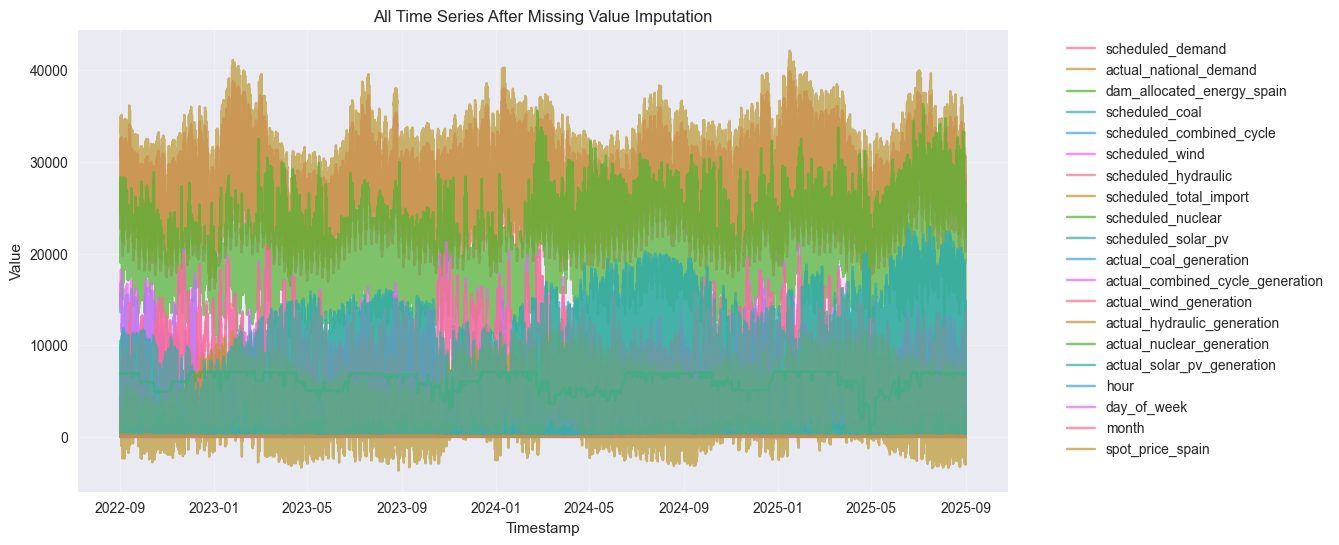

In [41]:
print(Dataset_indexed.isnull().sum())

num_cols = Dataset_indexed.select_dtypes(include=[np.number]).columns
Dataset_indexed[num_cols] = Dataset_indexed[num_cols].fillna(Dataset_indexed[num_cols].median())
print("Missing values after imputation:")
print(Dataset_indexed.isnull().sum())

#plot all time series again
plt.figure(figsize=(12,6))
for col in num_cols:
    plt.plot(Dataset_indexed.index, Dataset_indexed[col], label=col, alpha=0.7)
plt.title('All Time Series After Missing Value Imputation')
plt.xlabel('Timestamp'); plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()



